In [1]:
library("metacell")
library("Matrix")
library("ggplot2")
library("ggrepel")
library("tgstat")
library("zoo")
library("qvalue")
library("devtools")
library("data.table")
library("tidyverse")
library("tglkmeans")
library('RColorBrewer')


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: usethis

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.2      v dplyr   1.0.10
v tidyr   1.2.0      v stringr 1.4.0 
v readr   2.1.0      v forcats 1.0.0 
v purrr   0.3.4      

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x tidyr::expand()    masks Matrix::expand()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x tidyr::pack()      masks Matrix::pack()
x purrr::transpose() masks data.table::transpose()
x tidyr::unpack()    masks Matrix::unpack()



In [2]:
source("../scripts/manifold_2d_proj_hr.R")
scdb_init("../scrna_db/", force_reinit=T)

mat_id <- "exe"
mc_id <- "exe"

mat <- scdb_mat(mat_id)
mc <- scdb_mc(mc_id)
gset = scdb_gset("exe")
mc2d <- scdb_mc2d(id = "exe_umap")

md <- mat@cell_metadata

fig_dir <- "../figs/"
if(!dir.exists(fig_dir)) dir.create(fig_dir)
scfigs_init(fig_dir)

mat_embexe <- scdb_mat("embexe")
mc_embexe <- scdb_mc("embexe_recolored")
mc2d_embexe <- scdb_mc2d(id = "embexe_recolored_umap")
md_embexe <- mat_embexe@cell_metadata[names(mc_embexe@mc),]

initializing scdb to ../scrna_db/



In [3]:
exe_cells = colnames(mat@mat)[mat@cell_metadata[colnames(mat@mat),"Experiment"] != "Wildtype project"]
exe_cells_f = exe_cells[!is.na(md[exe_cells,"time_bin"])]

rank_vs_ct = table(mc@colors[mc@mc[exe_cells_f]],mat@cell_metadata[exe_cells_f,"transcriptional_rank"])
rank_vs_ct = rank_vs_ct[mc@color_key$color,]
rank_vs_ct = t(t(rank_vs_ct)/colSums(rank_vs_ct))

emb_age_df = unique(mat@cell_metadata[exe_cells_f,c("embryo","transcriptional_rank",
                                                    "time_bin","developmental_time")])
emb_age_df = emb_age_df[order(emb_age_df$transcriptional_rank),]

sum_age_exe <- emb_age_df %>% 
  group_by(time_bin) %>% 
  summarise(mean=round(mean(developmental_time),1))
sum_age_exe <- as.data.frame(sum_age_exe)

sc_time_annot = data.frame(cell = exe_cells_f,
                           embryo = mat@cell_metadata[exe_cells_f,"embryo"])
sc_time_annot = left_join(sc_time_annot,emb_age_df,by = "embryo")
f = !is.na(sc_time_annot$developmental_time)
sc_time = sc_time_annot$developmental_time[f]
names(sc_time) = sc_time_annot$cell[f]

col_to_ct =  mc@color_key$group
names(col_to_ct) = mc@color_key$color
ct_to_col = mc@color_key$color
names(ct_to_col) = mc@color_key$group

col_to_rank = c(1:nrow(mc@color_key))
names(col_to_rank) = mc@color_key$color
mc_time = tapply(sc_time,mc@mc[names(sc_time)],mean)
mc_new_ord = as.numeric(names(mc_time[order(as.numeric(mc_time))]))

shades_rdbu <- rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,"Blues"))(100)
shades_reds <- colorRampPalette(RColorBrewer::brewer.pal(9,"Reds"))(100)
shades_yellows <- colorRampPalette(RColorBrewer::brewer.pal(9,"YlOrBr"))(100)
shades_greys <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greys"))(100)
shades_greens <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greens"))(100)
shades_purples <- colorRampPalette(RColorBrewer::brewer.pal(9,"BuPu"))(100)

annotation_col = data.frame(ct = col_to_ct[mc@colors],stringsAsFactors = F)
rownames(annotation_col) = c(1:nrow(annotation_col))
annotation_colors = list(ct = ct_to_col)

In [4]:
chorion_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[1]]
tsc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[2]]
tsc2_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[3]]
spt_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[4]]
epc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[5]]
tgc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[6]]
ptgc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[7]]
spa_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[8]]

chorion_mcs = which(mc@colors == mc@color_key$color[1])
tsc_mcs = which(mc@colors == mc@color_key$color[2])
tsc2_mcs = which(mc@colors == mc@color_key$color[3])
spt_mcs = which(mc@colors == mc@color_key$color[4])
epc_mcs = which(mc@colors == mc@color_key$color[5])
tgc_mcs = which(mc@colors == mc@color_key$color[6])
ptgc_mcs = which(mc@colors == mc@color_key$color[7])
spa_mcs = which(mc@colors == mc@color_key$color[8])

chorion_mcs_ord = mc_new_ord[which(mc_new_ord %in% chorion_mcs)]
tsc_mcs_ord = mc_new_ord[which(mc_new_ord %in% tsc_mcs)]
tsc2_mcs_ord = mc_new_ord[which(mc_new_ord %in% tsc2_mcs)]
spt_mcs_ord = mc_new_ord[which(mc_new_ord %in% spt_mcs)]
epc_mcs_ord = mc_new_ord[which(mc_new_ord %in% epc_mcs)]
tgc_mcs_ord = mc_new_ord[which(mc_new_ord %in% tgc_mcs)]
ptgc_mcs_ord = mc_new_ord[which(mc_new_ord %in% ptgc_mcs)]
spa_mcs_ord = mc_new_ord[which(mc_new_ord %in% spa_mcs)]

mcs_all <- c(tsc_mcs_ord,tsc2_mcs_ord,chorion_mcs_ord,spt_mcs_ord,epc_mcs_ord,tgc_mcs_ord,spa_mcs_ord,ptgc_mcs_ord)
mcs_epc_lineage <- c(tgc_mcs_ord,epc_mcs_ord,spt_mcs_ord)
mcs_chorion_lineage <- c(tsc_mcs_ord,chorion_mcs_ord,tsc2_mcs_ord)

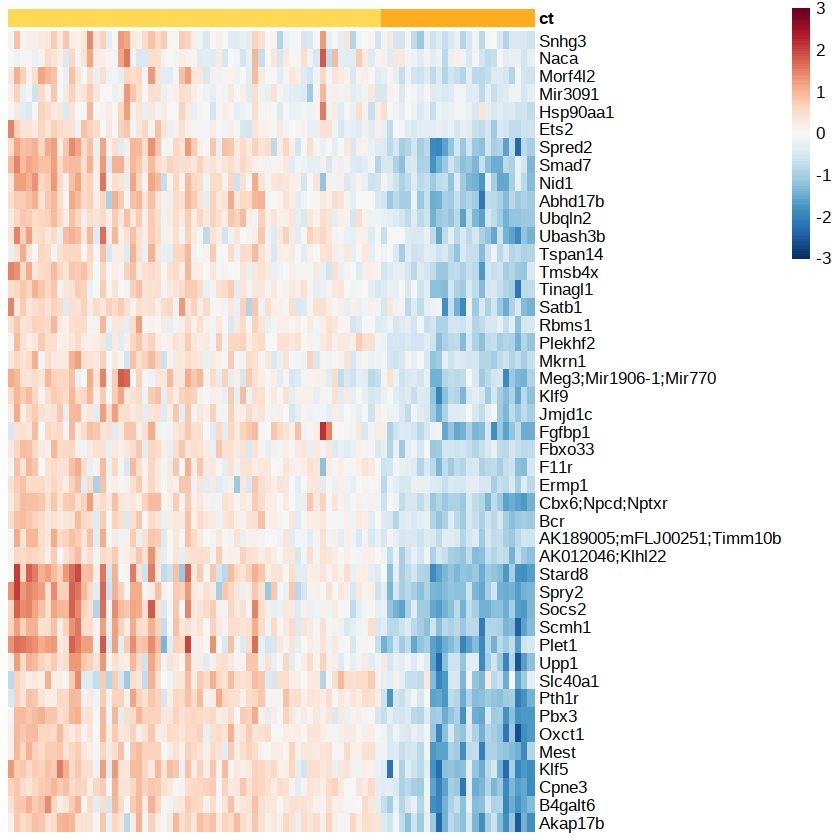

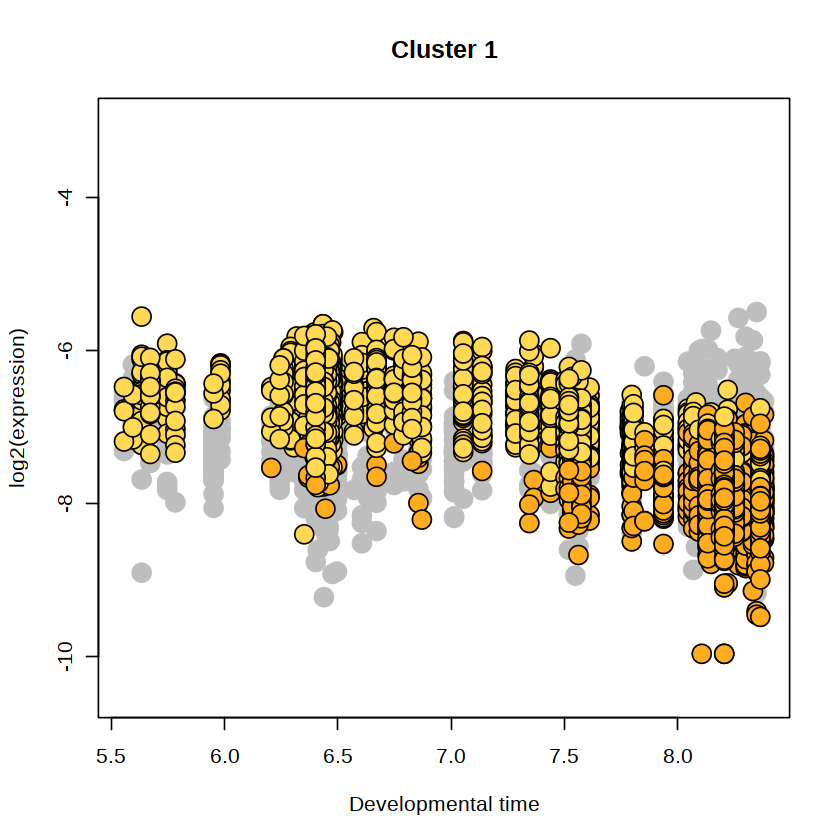

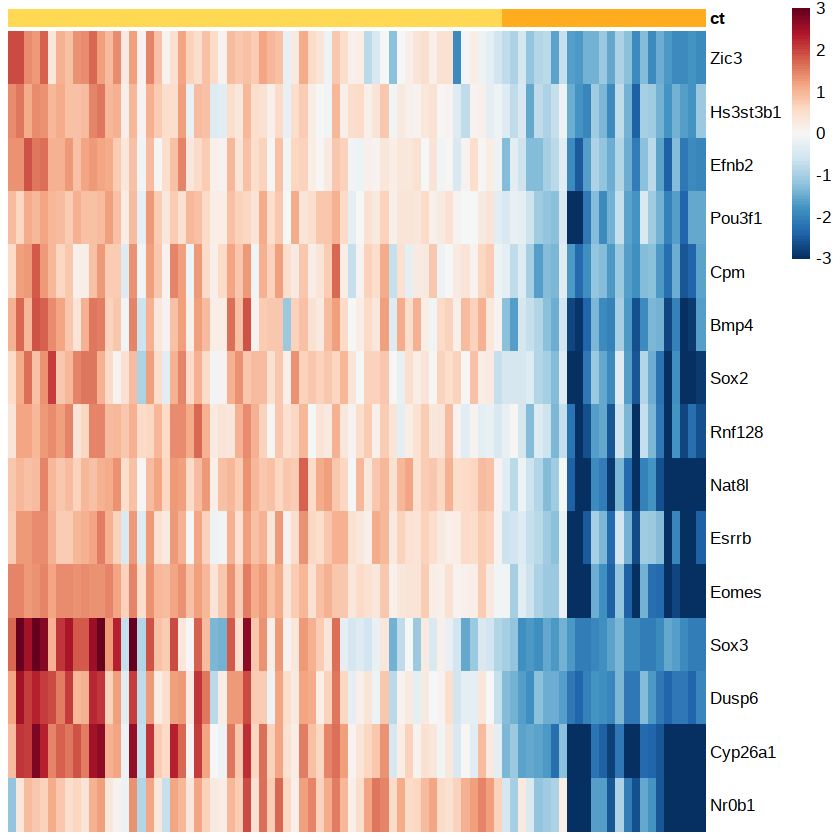

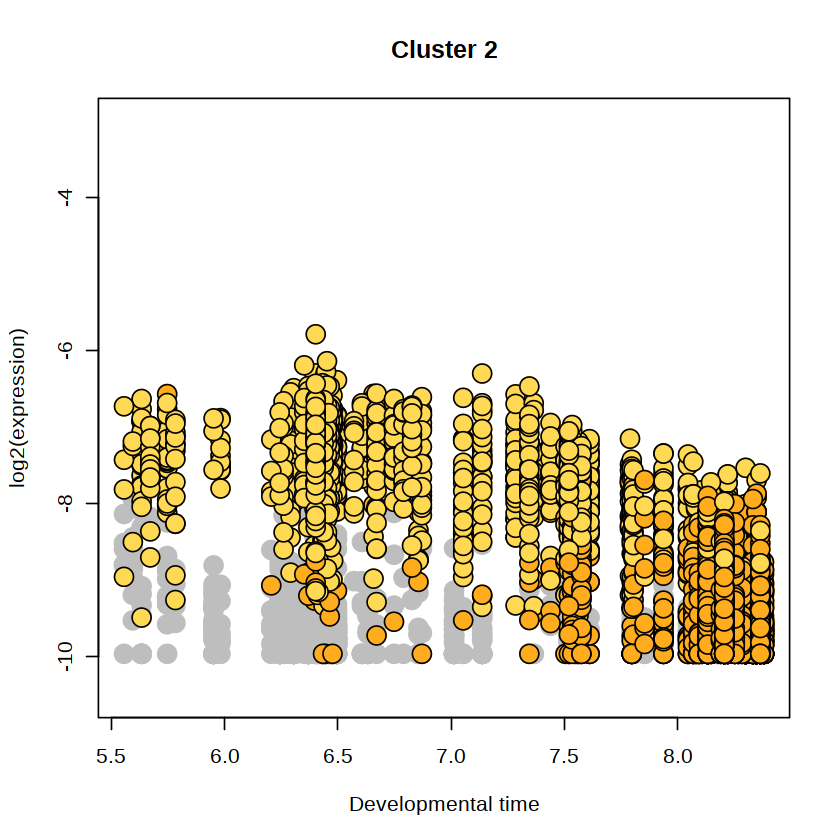

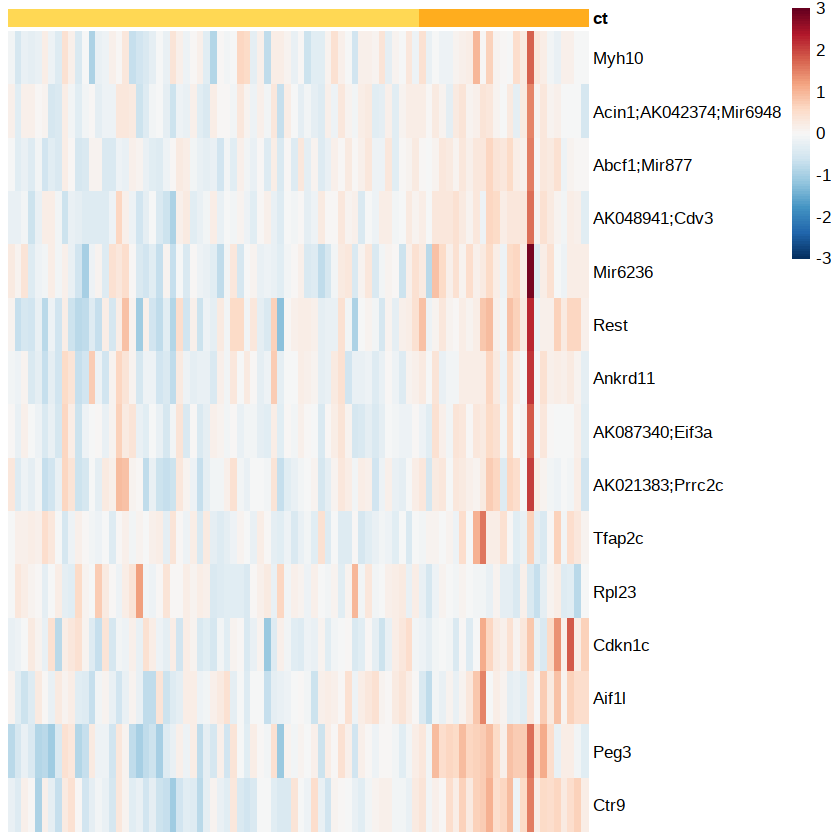

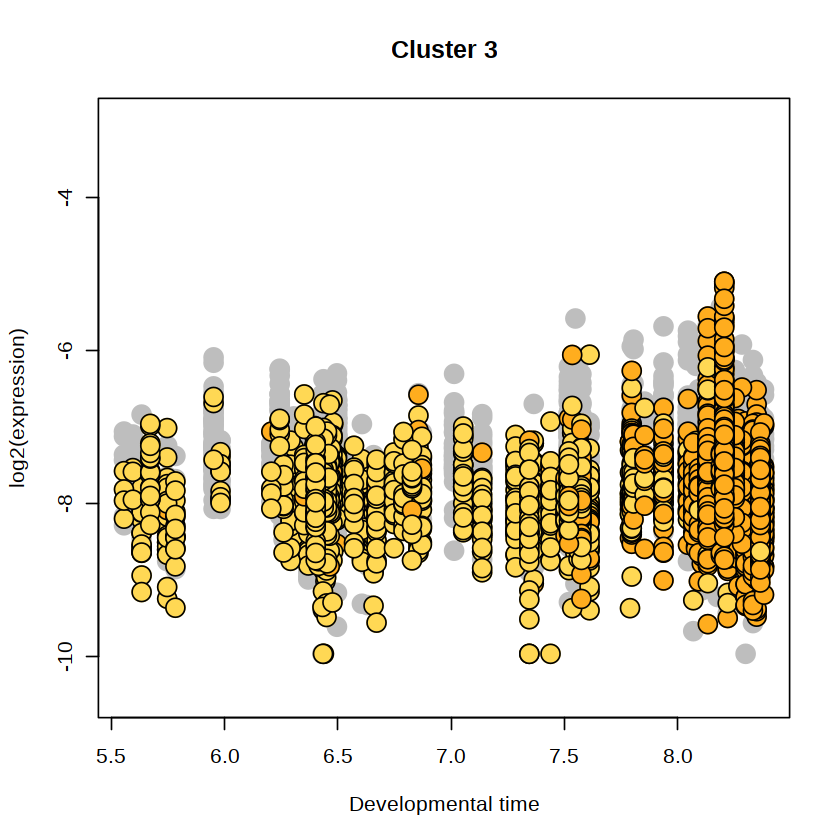

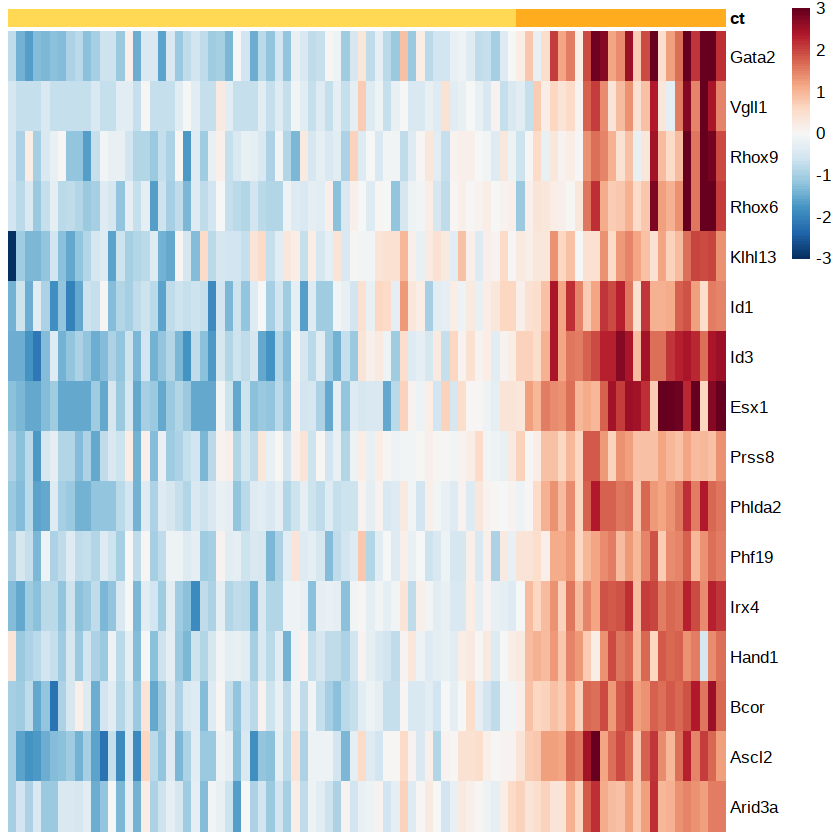

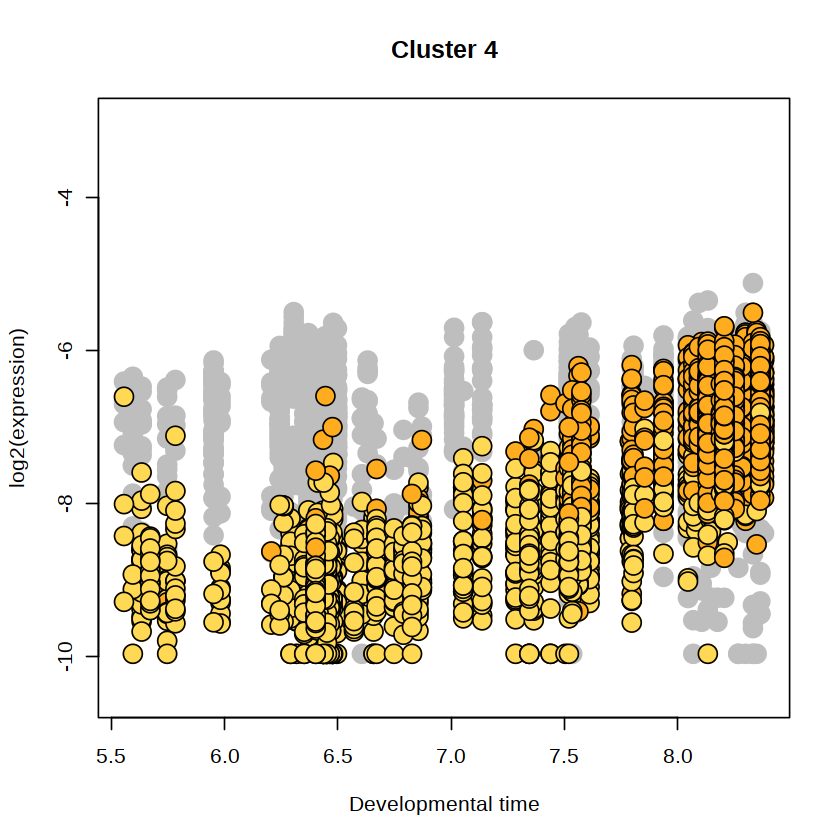

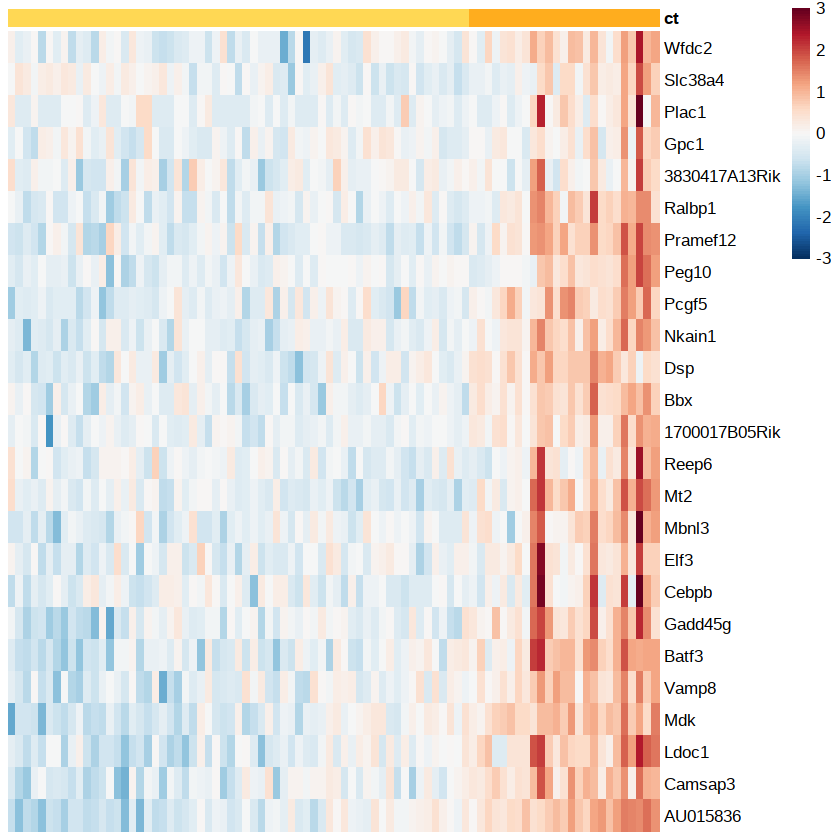

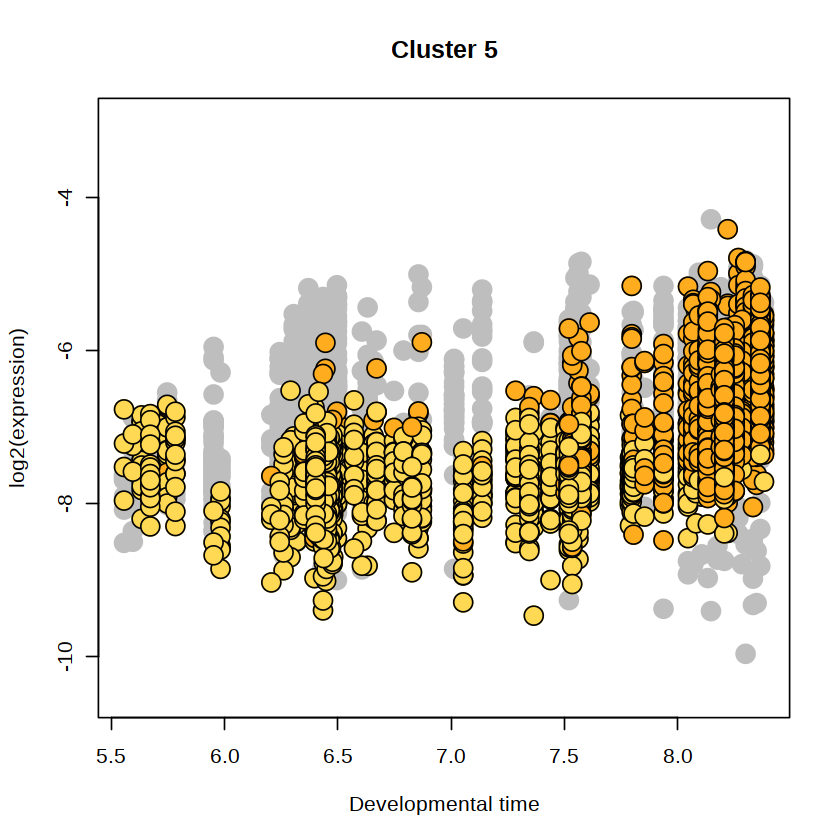

In [5]:
##### EDF4a ######
min_gexp <- -13
fc1 <- 2
fc2 = 1
k = 5
seed = 12
centers_tsc = 6
centers_chorion = 6

dge1 <- matrix(apply(log2(mc@e_gc[,c(tsc_mcs_ord,chorion_mcs_ord)] + 1e-5),1,min),dimnames = list(c(row.names(mc@e_gc))))
dge2 <- matrix(apply(log2(mc@e_gc[,c(tsc_mcs_ord,chorion_mcs_ord)] + 1e-5),1,max),dimnames = list(c(row.names(mc@e_gc))))
temp <- cbind(dge2[,1],dge1[,1])

colnames(temp) <- c("gexp.max", "gexp.min")
temp <- as.data.frame(temp)

temp$diff <- temp$gexp.max - temp$gexp.min
gns_by_exp <- rownames(temp)[temp$gexp.max > min_gexp]
gns_by_fc <- rownames(temp)[temp$diff > fc1]
gns_f1 <- intersect(gns_by_exp,gns_by_fc)

abs_df_diff <- abs(matrix(apply(log2(mc@e_gc[gns_f1,tsc_mcs] + 1e-5),1,max),dimnames = list(gns_f1)) - matrix(apply(log2(mc@e_gc[gns_f1,chorion_mcs] + 1e-5),1,max),dimnames = list(gns_f1)))

f2 = abs_df_diff[,1] > fc2
gns_f2 <- gns_f1[f2]

legc = log2(mc@e_gc + 1e-5)
legc_chorion = legc[,c(tsc_mcs_ord,chorion_mcs_ord)] - rowMeans(legc[,c(tsc_mcs_ord,chorion_mcs_ord)])

km_cl = TGL_kmeans(df = legc_chorion[gns_f2,],
                   k = k,
                   id_column = F,
                   seed = seed)

gene_cluster = km_cl$cluster
names(gene_cluster) = rownames(legc[gns_f2,])

f = mc@colors[mc@mc[exe_cells_f]] %in% mc@color_key$color[c(1,2)]
sc_col = ifelse(mc@colors[mc@mc[exe_cells_f]] %in% 
                  mc@color_key$color[c(1,2)],
                mc@colors[mc@mc[exe_cells_f]],"gray")
names(sc_col) <- exe_cells_f

shades = rev(colorRampPalette(RColorBrewer::brewer.pal(9,name = "RdBu"))(100))
breaks = seq(-3,3,length.out = 101)
n_umi_per_cell = colSums(mat@mat[,exe_cells_f])


for(gc in 1:k){
  gns <- names(gene_cluster)[as.numeric(gene_cluster) == gc]
  set.seed(1)
  k <- kmeans(legc_chorion[gns,],centers = 5)
  gns <- rev(names(as.array(k$cluster[order(as.numeric(k$cluster))])))
  pheatmap::pheatmap(mat = legc_chorion[gns,],
                     cluster_cols = F,
                     cluster_rows = F,
                     treeheight_row = 0,
                     show_colnames = F,
                     color = shades_rdbu,
                     breaks = breaks,
                     legend = T,
                     annotation_legend = F,
                     annotation_col = annotation_col,
                     border_color = NA,
                     annotation_colors = annotation_colors)
  
  plot(x = mat@cell_metadata[exe_cells_f,"developmental_time"],
       y = log2(colSums(mat@mat[gns,exe_cells_f])/n_umi_per_cell + 1e-3),
       pch = 19,
       col = sc_col,
       main = paste0("Cluster ",gc),
       cex = 2,
       xlab = "Developmental time",
       ylab = "log2(expression)",
       ylim = c(-10.5,-3))
  
  points(x = mat@cell_metadata[exe_cells_f[f],"developmental_time"],
         y = log2(colSums(mat@mat[gns,exe_cells_f[f]])/n_umi_per_cell[f] + 1e-3),
         pch = 21,
         col = "black",
         bg = sc_col[f],
         cex = 2)
}

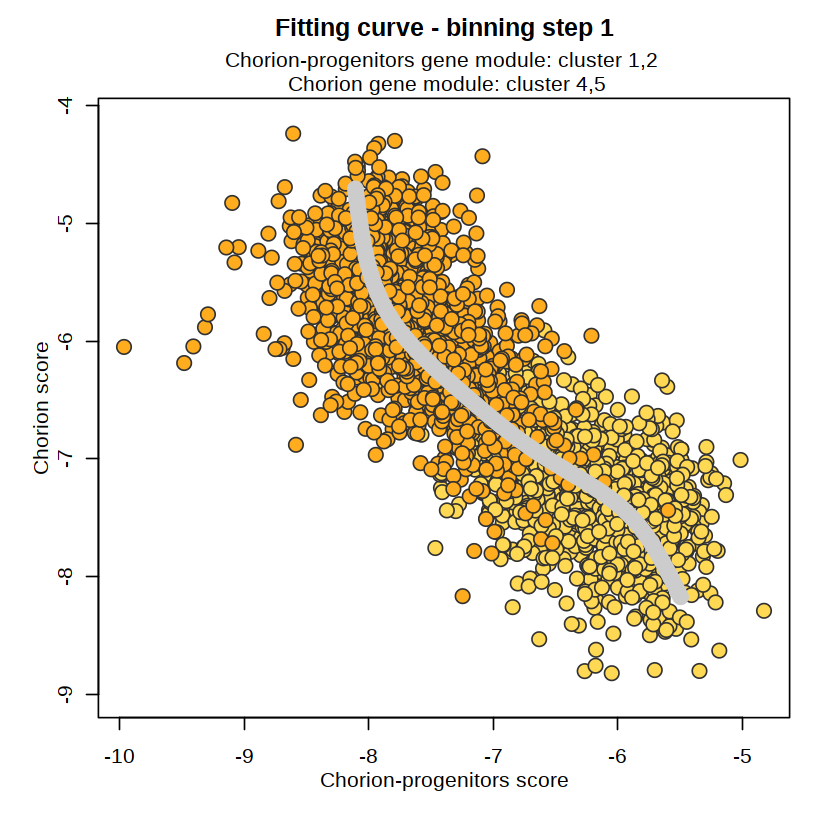

In [6]:
##### EDF4b #####
gn_clust_tsc <- c(1,2)
gn_clust_chorion <- c(4,5)

gns_tsc <- names(gene_cluster)[as.numeric(gene_cluster) %in% c(gn_clust_tsc)]
gns_chorion <- names(gene_cluster)[as.numeric(gene_cluster) %in% c(gn_clust_chorion)]

tsc_score = colSums(mat@mat[gns_tsc,exe_cells_f])/colSums(mat@mat[,exe_cells_f])
chorion_score = colSums(mat@mat[gns_chorion,exe_cells_f])/colSums(mat@mat[,exe_cells_f])

tsc_score <- log2(tsc_score + 1e-3)
chorion_score <- log2(chorion_score + 1e-3)

md <- mat@cell_metadata[exe_cells_f,]
cls_chorion_lineage <- c(tsc_cls,chorion_cls)
cls_chorion_lineage <- cls_chorion_lineage[cls_chorion_lineage %in% exe_cells_f]

chorion_cls_5 <- rownames(md)[md$time_bin == 1 & rownames(md) %in% cls_chorion_lineage]
chorion_cls_6 <- rownames(md)[md$time_bin == 2 & rownames(md) %in% cls_chorion_lineage]
chorion_cls_6.5 <- rownames(md)[md$time_bin == 3 & rownames(md) %in% cls_chorion_lineage]
chorion_cls_7 <- rownames(md)[md$time_bin == 4 & rownames(md) %in% cls_chorion_lineage]
chorion_cls_7.5 <- rownames(md)[md$time_bin == 5 & rownames(md) %in% cls_chorion_lineage]
chorion_cls_8 <- rownames(md)[md$time_bin == 6 & rownames(md) %in% cls_chorion_lineage]

chorion_cls_lst <- list("chorion_5.5"=chorion_cls_5,
                    "chorion_6"=chorion_cls_6,
                    "chorion_6.5"=chorion_cls_6.5,
                    "chorion_7"=chorion_cls_7,
                    "chorion_7.5"=chorion_cls_7.5,
                    "chorion_8"=chorion_cls_8)

df_curve = data.frame(tsc = tsc_score[cls_chorion_lineage],
                      chorion = chorion_score[cls_chorion_lineage])

cell_order = order(df_curve$chorion,decreasing = F)
df_curve = df_curve[cell_order,]

lm = princurve::principal_curve(x = as.matrix(df_curve), start = as.matrix(df_curve))

df_curve$lambda = lm$lambda


plot(x = tsc_score,
     y = chorion_score,
     pch = 19,
     col = NA,
     cex=1.5, xlab = NA, ylab = NA)

points(x = tsc_score[cls_chorion_lineage],
       y = chorion_score[cls_chorion_lineage],
       cex = 1.5,
       col="#313131",
       pch = 21,
       bg = sc_col[cls_chorion_lineage])
lines(lm, col = "#cccccc", lwd = 10)
title(main = "Fitting curve - binning step 1", 
      line = 2.6)
title(sub = sprintf("Chorion-progenitors gene module: cluster %s,%s \n Chorion gene module: cluster %s,%s",
                    gn_clust_tsc[1],gn_clust_tsc[2],gn_clust_chorion[1],gn_clust_chorion[2]), 
      line = -27)
title(xlab = "Chorion-progenitors score",
      line = 2)
title(ylab = "Chorion score",
      line = 2)

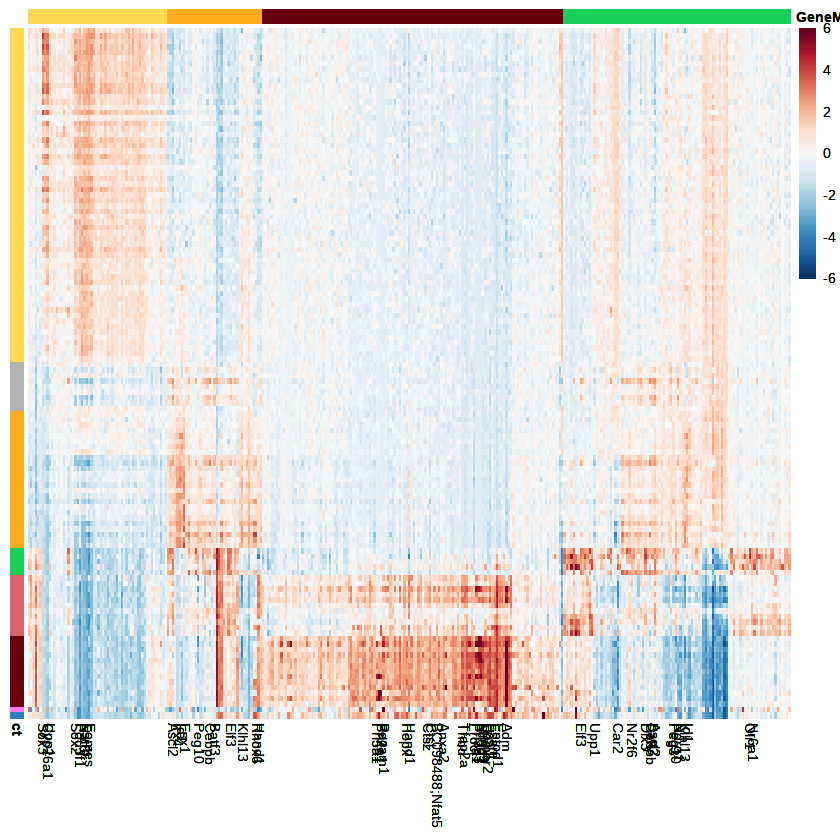

In [7]:
##### EDF4c #####
tsc_gm <- read.table("../data/tsc_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]
tgc_gm <- read.table("../data/tgc_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]
spt_gm <- read.table("../data/spt_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]
chorion_gm <- read.table("../data/chorion_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]
gns <- c(tsc_gm,chorion_gm,tgc_gm,spt_gm)

annotation_col = data.frame(ct = col_to_ct[mc@colors],stringsAsFactors = F)
rownames(annotation_col) = c(1:nrow(annotation_col))

annotation_rows <- data.frame(GeneModule = factor(rep(c("Chorion-progenitors","Chorion","TGC-progenitors","SpT-Gly"),
                                                      c(length(tsc_gm),length(chorion_gm),length(tgc_gm),length(spt_gm)))))
rownames(annotation_rows) <- paste("Gene",1:length(gns))

gm_to_col <- c("#ffd854","#ffad1e","#67000d","#19ce5b")
names(gm_to_col) <- c("Chorion-progenitors","Chorion","TGC-progenitors","SpT-Gly")

annotation_colors = list(ct = ct_to_col, GeneModule = gm_to_col)

legc = log2(mc@e_gc + 1e-5)
legc_n = legc[,mcs_all] - rowMeans(legc[,mcs_all])

set.seed(1)
x_tsc <- kmeans(legc_n[tsc_gm,],centers = 6, iter.max = 500)
gns_tsc <- rev(names(as.array(x_tsc$cluster[order(as.numeric(x_tsc$cluster))])))

set.seed(1)
x_chorion <- kmeans(legc_n[chorion_gm,],centers = 8, iter.max = 500)
gns_chorion <- rev(names(as.array(x_chorion$cluster[order(as.numeric(x_chorion$cluster))])))

set.seed(1)
x_tgc <- kmeans(legc_n[tgc_gm,],centers = 5, iter.max = 500)
gns_tgc <- rev(names(as.array(x_tgc$cluster[order(as.numeric(x_tgc$cluster))])))

set.seed(1)
x_spt <- kmeans(legc_n[spt_gm,],centers = 6, iter.max = 500)
gns_spt <- rev(names(as.array(x_spt$cluster[order(as.numeric(x_spt$cluster))])))
gns <- c(gns_tsc,gns_chorion,gns_tgc,gns_spt)

breaks = seq(-6,6,length.out = 101)

gns <- c(gns_tsc,gns_chorion,gns_tgc,gns_spt)

legc = log2(mc@e_gc + 1e-5)
legc_n = legc[,mcs_all] - rowMeans(legc[,mcs_all])
legc_n <- legc_n[gns,]

mark <- c("Akt1;Mir6939","Ninj1","Ezr","AF465519;Tagln2","Tfap2c","Krt18","Nr2f6","Cebpb","Batf3",
          "Ugp2","Gata3","Lgals1","Krt7","Olr1","Dlx3","Ndrg1","Car2","Peg3","Tfap2a",
          "Nr6a1","Gjb5","Ascl2","Elf3","Adm","Cdh5","Entpd1","Esam","Hand1","Hopx",
          "Ctsl","Anxa2","Fosl1","Thbd","Procr","Homer2","Pecam1","Mmp9","Prl7a1",
          "Prl3d1","Prl3d3","Ctsz","Prl2a1","Prl4a1","Prl5a1","Il1r2","BC098488;Nfat5",
         "Sox3","Upp1","Cyp26a1","Nat8l","Esrrb","Eomes","Sox2","Pou3f1",
          "Esx1","Klhl13","Esx1","Id1","Irx4","Peg10","Cebpb","Rhox6")

gns_to_mark <- rep('',length(gns))
gns_to_mark[which(gns %in% mark)] <- gns[which(gns %in% mark)]
rownames(legc_n) <- paste("Gene",1:nrow(legc_n))

p <- pheatmap::pheatmap(mat = t(legc_n),fontsize = 8,
                        cluster_cols = F,
                        cluster_rows = F,
                        treeheight_row = 0,
                        show_colnames = T,
                        show_rownames= F,
                        breaks = breaks,
                        labels_col = gns_to_mark,
                        color = shades_rdbu,
                        legend = T,
                        annotation_legend = F,
                        annotation_col = annotation_rows,
                        annotation_row = annotation_col,
                        border_color = NA,
                        annotation_colors = annotation_colors)

print(p)

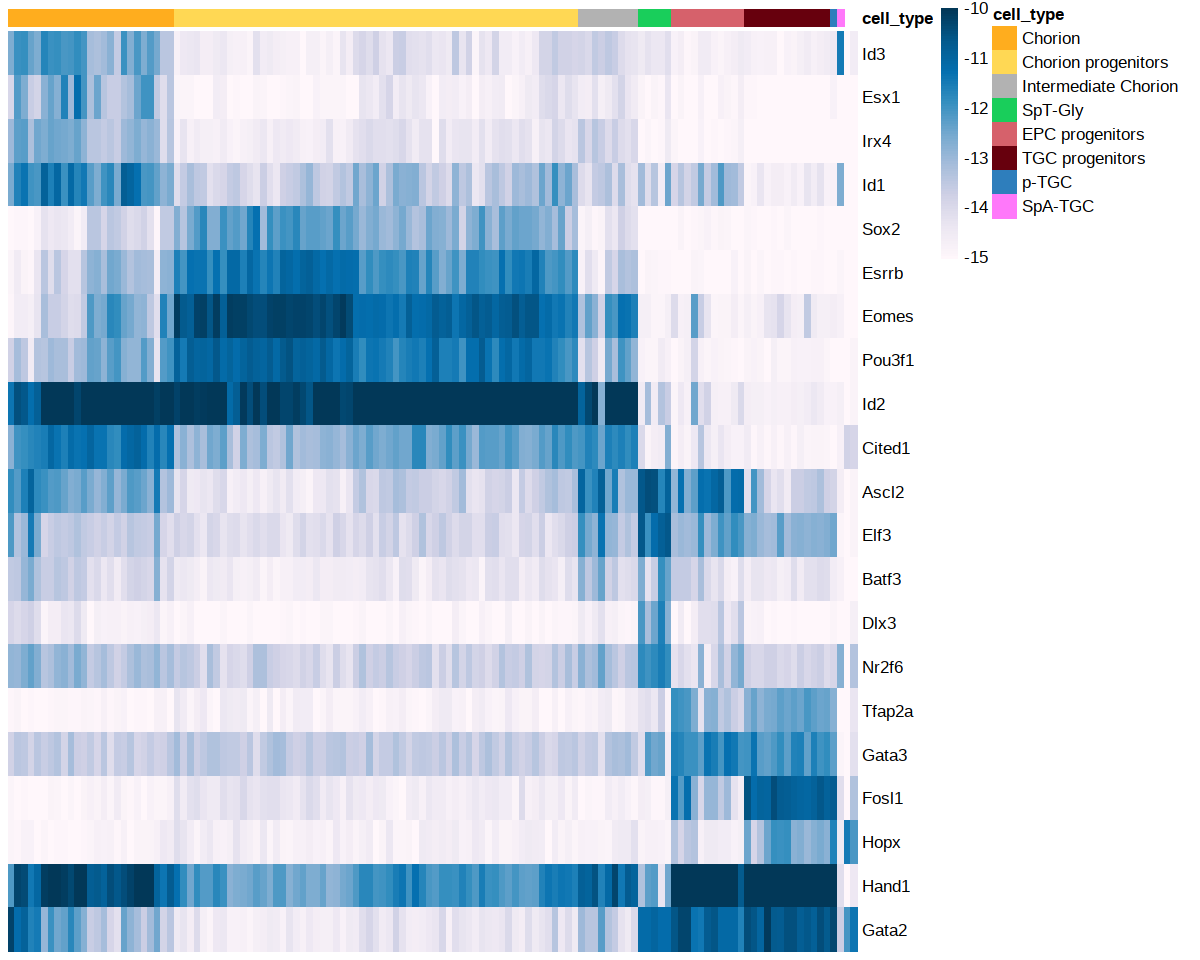

In [8]:
##### EDF4d #####
legc = log2(mc@e_gc +3e-5)
chorion_progenitor_tfs = c("Sox2","Esrrb","Eomes","Pou3f1")
chorion_tfs = c("Id3","Esx1","Irx4","Id1")
shared_tfs  = c("Id2","Cited1","Ascl2")
intermediate_exe_tfs = c("Elf3","Batf3")
spt_tfs = c("Dlx3","Nr2f6")
epc_tfs = c("Tfap2a","Gata3","Fosl1","Hopx","Hand1","Gata2")

all_tfs = c(chorion_tfs,chorion_progenitor_tfs,shared_tfs,intermediate_exe_tfs,spt_tfs,epc_tfs)
col_to_ct = mc@color_key$group[1:8]
names(col_to_ct) = mc@color_key$color[1:8]
ct_to_col = mc@color_key$color[1:8]
names(ct_to_col) = mc@color_key$group[1:8]

ct_annotation = data.frame(cell_type = col_to_ct[mc@colors])
rownames(ct_annotation) = 1:ncol(mc@e_gc)

annotation_colors = list(cell_type = ct_to_col)
shades = rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
shades_egc = colorRampPalette(RColorBrewer::brewer.pal(9,name = "PuBu"))(100)
breaks = seq(-3,3,length.out = 101)
breaks_egc = seq(log2(1e-5),-9,length.out = 101)

legc_n = legc - log2(1e-5)
legc_n = legc_n[all_tfs,]/apply(legc_n[all_tfs,],1,max)
legc_n = pmin(legc,-10)

col_to_rank = c(1:8)
names(col_to_rank) = mc@color_key$color[1:8]

mc_ord = order(100*col_to_rank[mc@colors] + c(1:ncol(mc@e_gc)))

options(repr.plot.width=10, repr.plot.height=8)
pheatmap::pheatmap(mat = legc_n[all_tfs,mc_ord],
                   show_colnames = F,
                   color = shades_egc,
                   treeheight_row = 0,
                   treeheight_col = 0,
                   annotation_legend = T,
                   annotation_col = ct_annotation,
                   annotation_colors = annotation_colors,
                   cluster_cols = F,
                   cluster_rows = F)

Joining, by = "embryo"


png 
  2

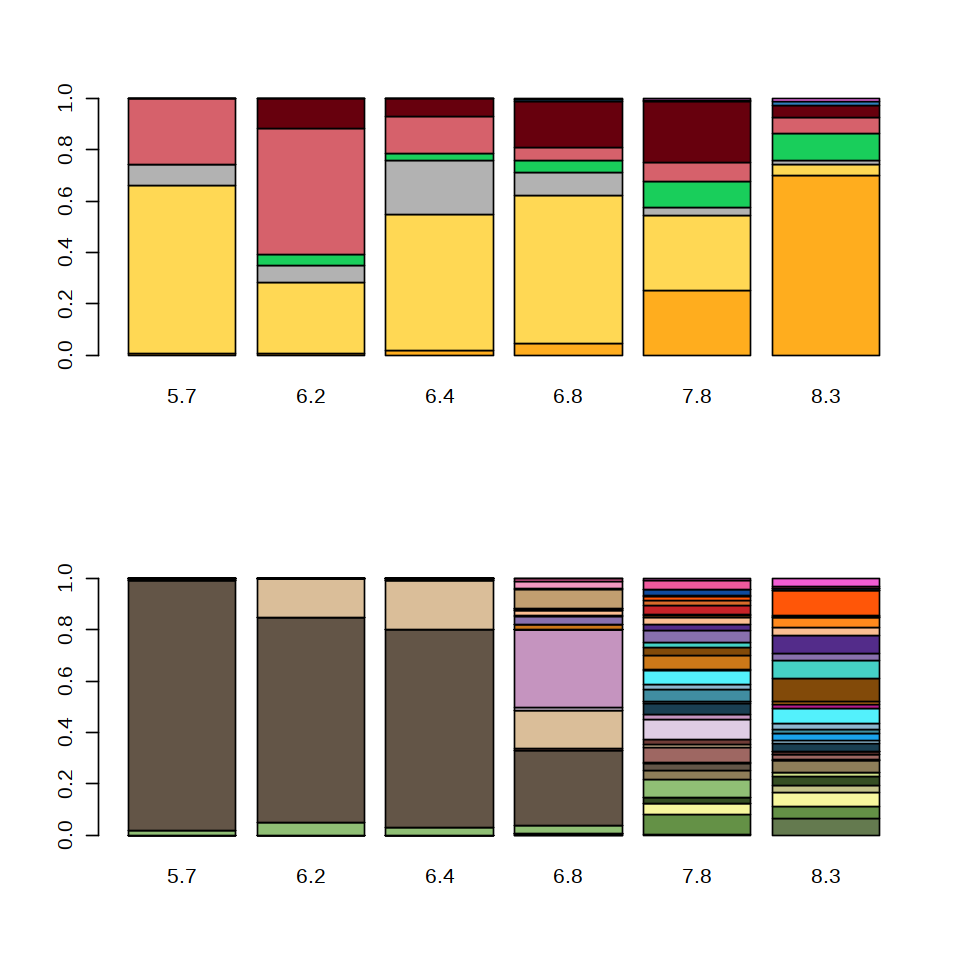

In [86]:
##### EDF4e #####
df_embryo_rank = as.data.frame(fread('../data/embexe.transcriptional_rank_developmental_time_with_age_group.tsv'))
time_bin_exe_df = mat@cell_metadata %>% select(embryo,time_bin) %>% distinct(embryo, .keep_all = TRUE) %>% filter(embryo %in% df_embryo_rank$embryo)
df_embryo_rank = df_embryo_rank %>% left_join(time_bin_exe_df) %>% filter(!is.na(time_bin))
time_bin_df = df_embryo_rank %>% group_by(time_bin) %>% summarise(Et = round(mean(developmental_time),1), N = n())

list_of_embs_per_tb = list()

for(tb in 1:6){
    
    embs = df_embryo_rank %>% filter(time_bin == tb) %>% pull(embryo)
    list_of_embs_per_tb[[paste("tb",tb,"_embs", sep = "")]] = embs
}

cols_to_include = mc_embexe@color_key$color[c(1:38,43:50)]
emb_cols = mc_embexe@color_key$color[c(1:38)]
exe_cols = mc_embexe@color_key$color[c(43:50)]

time_bin_names = names(list_of_embs_per_tb)
rank_vs_emb_ct_per_tb = list()
rank_vs_exe_ct_per_tb = list()

for(time_bin_name in time_bin_names){
    cells_in_time_bin <- md_embexe$cell[md_embexe$embryo %in% list_of_embs_per_tb[[time_bin_name]]] 
    rank_vs_ct = table(factor(mc_embexe@colors[mc_embexe@mc[cells_in_time_bin]],cols_to_include), md_embexe[cells_in_time_bin,"transcriptional_rank"])
    rank_vs_ct_emb = rank_vs_ct[rownames(rank_vs_ct) %in% emb_cols,]
    rank_vs_ct_exe = rank_vs_ct[rownames(rank_vs_ct) %in% exe_cols,]
    
    rank_vs_emb_ct_per_tb[[time_bin_name]] <- rowSums(rank_vs_ct_emb)/sum(rank_vs_ct_emb)
    rank_vs_exe_ct_per_tb[[time_bin_name]] <- rowSums(rank_vs_ct_exe)/sum(rank_vs_ct_exe)
}

rank_vs_emb_ct_per_tb = do.call(cbind,rank_vs_emb_ct_per_tb)
colnames(rank_vs_emb_ct_per_tb) = as.character(time_bin_df$Et)

rank_vs_exe_ct_per_tb = do.call(cbind,rank_vs_exe_ct_per_tb)
colnames(rank_vs_exe_ct_per_tb) = as.character(time_bin_df$Et)

options(repr.plot.width=8, repr.plot.height=8)
par(mfrow = c(2,1))
barplot(rank_vs_exe_ct_per_tb, col = rownames(rank_vs_exe_ct_per_tb))
barplot(rank_vs_emb_ct_per_tb, col = rownames(rank_vs_emb_ct_per_tb))

pdf("../figs/EDF4_f.pdf",width = 8,height = 8, useDingbats = F)
par(mfrow = c(2,1))
barplot(rank_vs_exe_ct_per_tb, col = rownames(rank_vs_exe_ct_per_tb))
barplot(rank_vs_emb_ct_per_tb, col = rownames(rank_vs_emb_ct_per_tb))
dev.off()